In [19]:
#!/usr/bin/env python
# coding: utf-8

# ## Data Cleaning and Preprocessing

# In[44]:


# Import dependencies
import pandas as pd
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password


# In[45]:


# Read in files
df = pd.read_csv('/content/bitcoin_data.csv')


# In[46]:


# Display initial data
df.head(10)


# In[47]:


# Drop all nulls
# df = df.dropna()


# In[48]:


# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price']].reset_index(drop=True)
df


# In[49]:


# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)


# In[50]:


# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# .strftime('%Y-%m-%d %H:%M:%S')
    
# Convert from Unix to UTC time
#df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].\
#    apply(lambda x: datetime.datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))


# In[51]:


# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")

# Machine learning section
# possible implementation ideas:
# 1. time series forecasting bitcoin price with ARIMA(Auto Regressive Integrated Moving Average)
# Rational for using time series: the 4 components of time series are trends, seasonality (consistent trends that span 1 calender year), noise/irregularity, and cyclicity(trends that can be observed in <1 or >1 year); this is perfect for tradeable assets 
# Qualifying criteria: the dataset must be stationary in order to more accurately fit a time series model. Stationary means that there should be a constant mean with constant std deviation or variance
# We can test if a time series is stationary by plotting the moving avg and/or movning std dev. to see if it changes over time. These results can be supported with an ADCF test
# if testing reveals our time series is NOT stationary, we can perform a variety of transformations to change it (log transform, sq rt, exponential decay etc..)
# SARIMA is ARIMA with a seasonality component. 


# ### PGAdmin SQL Schema

# In[56]:


# db schema thoughts: can create multiple tables for each currency (1 for btc, 1 ethereum, 1 xrp)
# can also add in additional tables down the line to support our analysis (table with google analytics, table with twitter search results for sentiment analysis)


# In[57]:


# View final dataset column names
final_df.head(5)


# In[58]:


# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC',
                  'time_delta':'timeDelta'
                 }, axis='columns', inplace=True)


# Checking datatypes
final_df.dtypes


# In[61]:


# Verifying final dataframe
final_df.head(2)

Percentage of total Bitstamp data lost due to dropping rows with NaN values: 27.14%
Ratio of Bitstamp rows dropped: 1,240,496/4,571,033
Total dataset contains 3174.33 days worth of data. Due to data loss, we had to drop 861.46 days worth of data


,timestamp,high,low,volume,weightedPrice,timestampSTR,timestampINT,timeUTC
0,1325391360,4.58,4.58,1.502,4.58,1325391360,1325391360,2012-01-01 04:16:00
1,1325431680,4.84,4.84,10.000,4.84,1325431680,1325431680,2012-01-01 15:28:00


In [20]:
print(len(final_df))
final_df['normalised_date'] = final_df['timeUTC'].dt.normalize()
final_df.head()
print(len(final_df))

3330537
3330537


In [28]:
final_df['date_only'] = final_df['normalised_date']
aggregated_df = final_df.groupby(final_df.normalised_date.dt.date).mean()
print(len(aggregated_df))
print(aggregated_df.columns)
aggregated_df


3177
Index(['timestamp', 'high', 'low', 'volume', 'weightedPrice', 'timestampINT'], dtype='object')


,timestamp,high,low,volume,weightedPrice,timestampINT
normalised_date,,,,,,
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,1.325427e+09
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,1.325535e+09
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,1.325605e+09
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,1.325682e+09
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,1.325771e+09
...,...,...,...,...,...,...
2020-09-10,1.599739e+09,10343.558552,10334.291588,7.119214,10339.359896,1.599739e+09
2020-09-11,1.599826e+09,10306.071361,10299.283936,3.660672,10303.242947,1.599826e+09
2020-09-12,1.599912e+09,10375.469839,10370.388713,1.754713,10373.259995,1.599912e+09


In [36]:
 # importing dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
#from pmdarima import auto_arima as AA
import warnings
import os
#from statsmodels.tsa.statespace.sarimax import SARIMAX
import regex as re

#date_price_df = final_df[['timeUTC','weightedPrice']]
#btc_2012_to_2017_df = date_price_df[date_price_df['timeUTC'].dt.date <= pd.to_datetime('2017-01-01')]
date_price_df = aggregated_df[['weightedPrice']]


y_2012 = date_price_df.loc[datetime.date(year=2012,month=1,day=1):datetime.date(year=2012,month=12,day=31)]
y_2013 = date_price_df.loc[datetime.date(year=2013,month=1,day=1):datetime.date(year=2013,month=12,day=31)]
y_2014 = date_price_df.loc[datetime.date(year=2014,month=1,day=1):datetime.date(year=2014,month=12,day=31)]
y_2015 = date_price_df.loc[datetime.date(year=2015,month=1,day=1):datetime.date(year=2015,month=12,day=31)]
y_2016 = date_price_df.loc[datetime.date(year=2016,month=1,day=1):datetime.date(year=2016,month=12,day=31)]
y_2017 = date_price_df.loc[datetime.date(year=2017,month=1,day=1):datetime.date(year=2017,month=12,day=31)]
y_2018 = date_price_df.loc[datetime.date(year=2018,month=1,day=1):datetime.date(year=2018,month=12,day=31)]
y_2019 = date_price_df.loc[datetime.date(year=2019,month=1,day=1):datetime.date(year=2019,month=12,day=31)]

#y_2012 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2012-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2013-01-01'))]
#y_2013 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2013-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2014-01-01'))]
#y_2014 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2014-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2015-01-01'))]
#y_2015 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2015-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2016-01-01'))]
#y_2016 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2016-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2017-01-01'))]
#y_2017 = btc_2012_to_2017_df[(btc_2012_to_2017_df['timeUTC'].dt.date >= pd.to_datetime('2017-01-01')) & (btc_2012_to_2017_df['timeUTC'].dt.date < pd.to_datetime('2018-01-01'))]

#y=btc_2012_to_2017_df.set_index(['timeUTC'])
#y.sort_index(inplace=True)
#y.dropna(inplace=True)
#y['weightedPrice']
y_2012.head()

,weightedPrice
normalised_date,
2012-01-01,4.806667
2012-01-02,5.000000
2012-01-03,5.252500
2012-01-04,5.208159
2012-01-05,6.284127


In [41]:
y=aggregated_df[['weightedPrice']]

In [37]:
#y_2012 = y_2012.set_index(['timeUTC'])
#y_2013 = y_2013.set_index(['timeUTC'])
#y_2014 = y_2014.set_index(['timeUTC'])
#y_2015 = y_2015.set_index(['timeUTC'])
#y_2016 = y_2016.set_index(['timeUTC'])
#y_2017 = y_2017.set_index(['timeUTC'])
y_2012.tail()

,weightedPrice
normalised_date,
2012-12-27,13.098514
2012-12-28,13.167550
2012-12-29,13.217500
2012-12-30,13.216034
2012-12-31,13.196513


In [38]:
print(f'length of data:\n 2012: {len(y_2012)}\n 2013: {len(y_2013)}\n 2014: {len(y_2014)}\n 2015: {len(y_2015)}\n 2016: {len(y_2016)}\n 2017: {len(y_2017)}\n 2018: {len(y_2018)}\n 2019: {len(y_2019)}')

length of data:
 2012: 366
 2013: 365
 2014: 365
 2015: 362
 2016: 366
 2017: 365
 2018: 365
 2019: 365


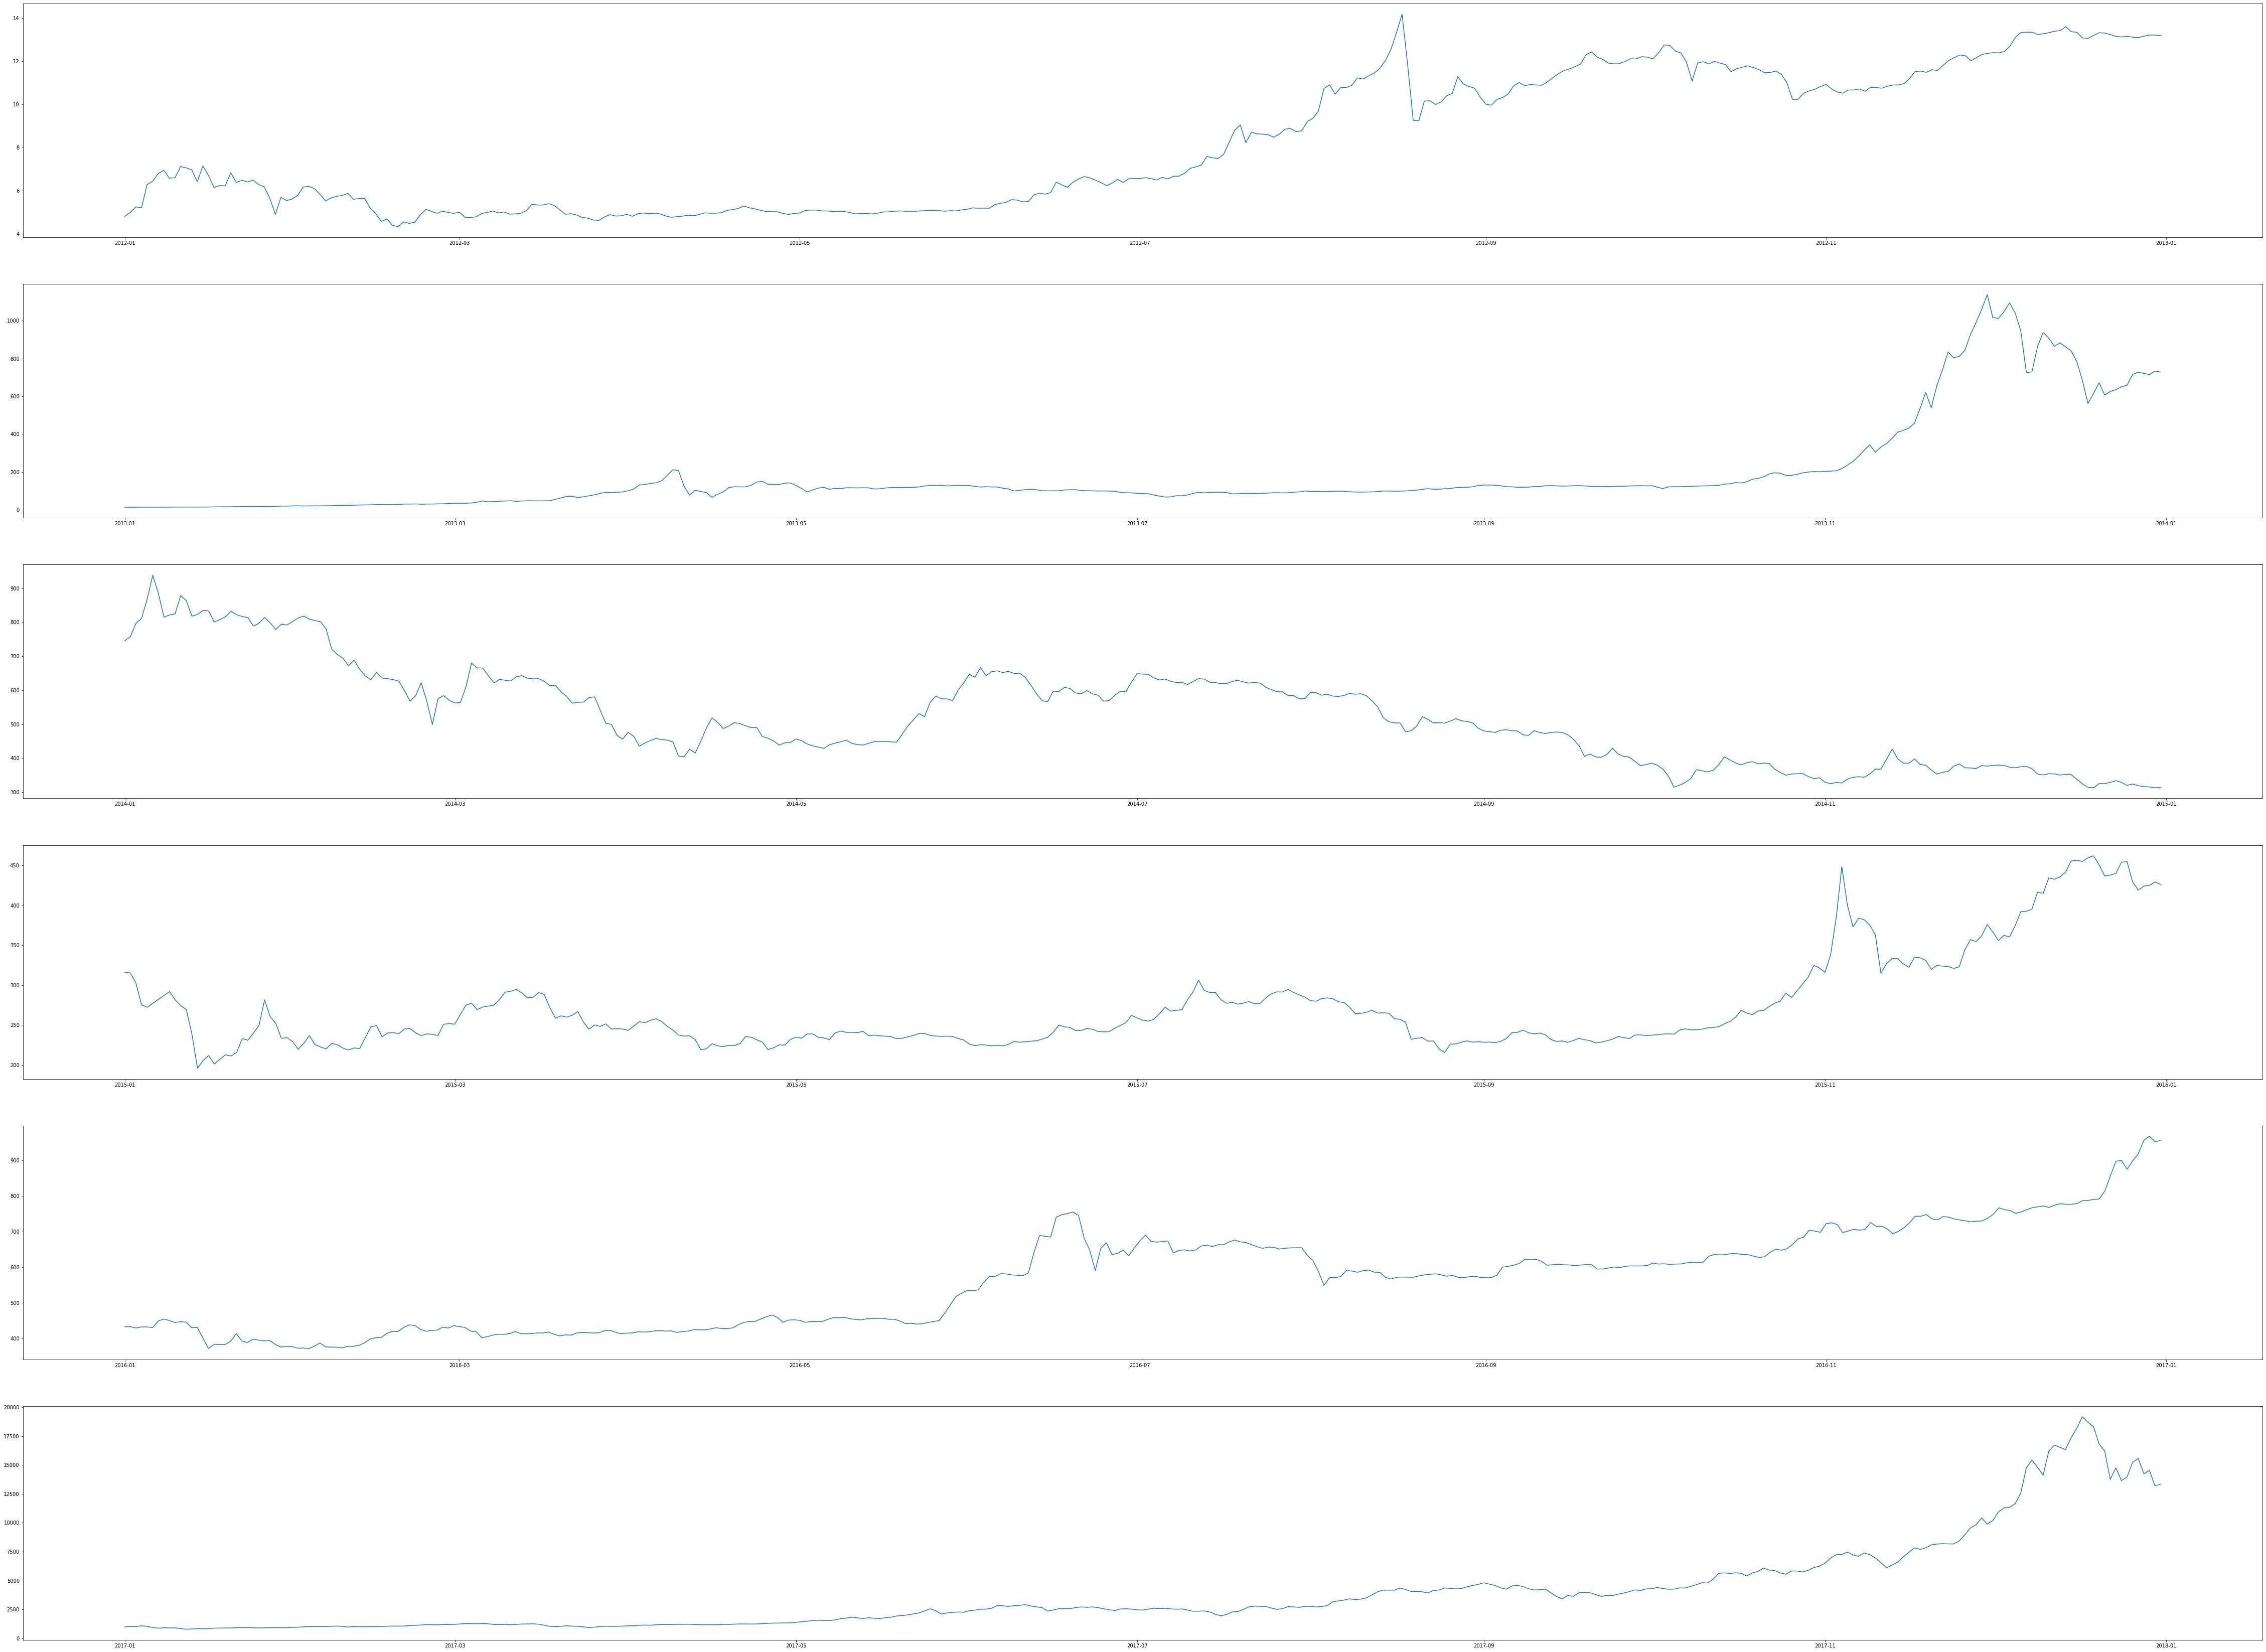

In [39]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6, figsize=(80, 60))
#y_2012.plot(figsize=(19, 4))
ax1.plot(y_2012)
ax2.plot(y_2013)
ax3.plot(y_2014)
ax4.plot(y_2015)
ax5.plot(y_2016)
ax6.plot(y_2017)

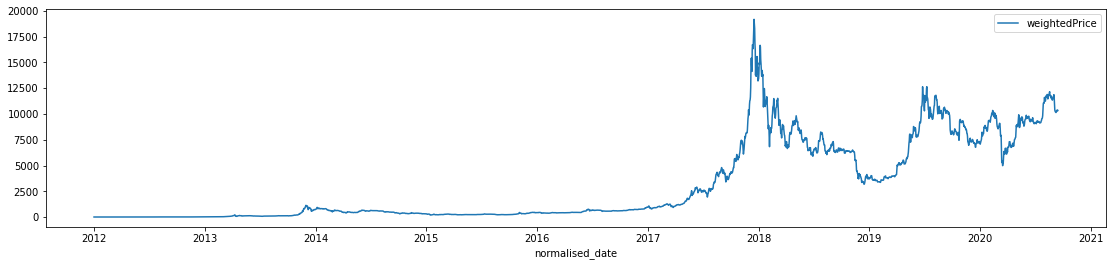

In [42]:
y.plot(figsize=(19, 4))
plt.show()


In [ ]:
print(len(y))

1470241


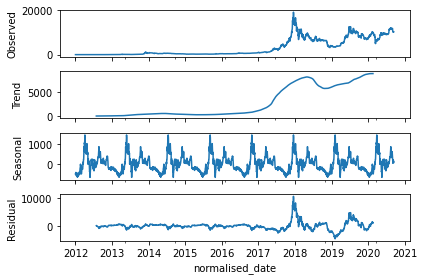

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(x=y['weightedPrice'], model='additive', freq=416)
fig = decomposition.plot()
plt.show()

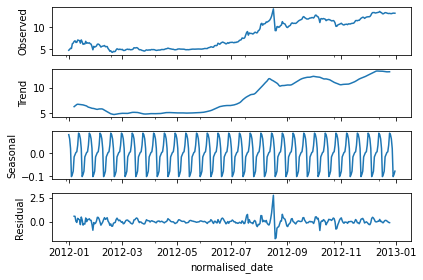

In [59]:
decomposition = seasonal_decompose(x=y_2012, model='additive', freq=12)
fig = decomposition.plot()
plt.show()

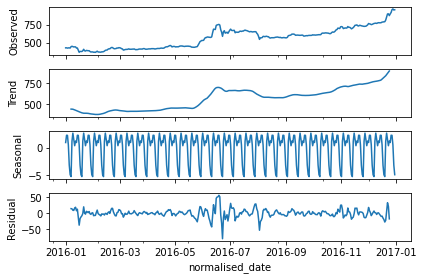

In [60]:
decomposition = seasonal_decompose(x=y_2016, model='additive', freq=12)
fig = decomposition.plot()
plt.show()

In [61]:
# importing and setting dependencies
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib
from statsmodels.tsa.statespace.sarimax import SARIMAX

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'G'

In [62]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [63]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_2012,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2626.3630968359166
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2131.400058044209
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:934.5190678100298
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:900.3704536466385
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:923.0587172530381
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:917.5316591314058
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:902.7875052823033
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:898.901190916114
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2128.0411503059913
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:1662.7549183448912
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:587.1906618872163
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:560.1525490971308
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:586.9771091436071
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:576.678074093452
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:563.1772992290337
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:545.9800101142384
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:156.07112172503628
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:140.77002871676237
ARIMA(0

In [64]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_2016,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:5686.118594124428
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:5515.037653113522
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:3773.548364130588
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:3628.3812965559605
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:3746.8768833524327
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:3732.44295179902
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:3642.772491490855
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:3627.1301418194143
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5184.417697984891
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:5034.9468476627435
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:3377.787291509313
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:3254.0620210651873
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3366.6423673332174
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3349.2361638251205
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:3276.668368782389
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:3252.4186452382564
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2849.886553917122
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2757.2531585368106
AR

In [ ]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_2015,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

In [65]:
# getting best model parameters based on AIC (lower the better)
# ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:101.50628412868633
mod = sm.tsa.statespace.SARIMAX(y_2012,
                                order=(1, 1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2780      0.102     -2.726      0.006      -0.478      -0.078
ma.L1          0.6073      0.100      6.049      0.000       0.410       0.804
ar.S.L12      -0.4541      0.092     -4.921      0.000      -0.635      -0.273
ma.S.L12       0.4580      0.102      4.512      0.000       0.259       0.657
sigma2         0.0754      0.002     38.140      0.000       0.072       0.079


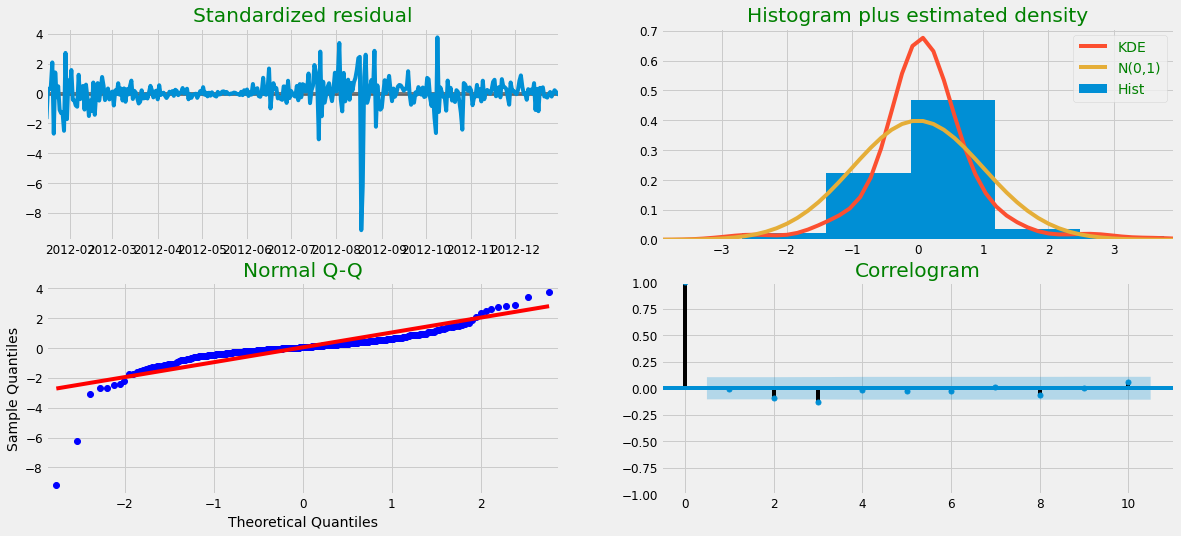

In [66]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

In [67]:
# y_2016
# ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:2661.586006922128
mod = sm.tsa.statespace.SARIMAX(y_2016,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0720      0.105     -0.689      0.491      -0.277       0.133
ma.L1          0.3459      0.103      3.345      0.001       0.143       0.549
ar.S.L12       0.0013      0.046      0.029      0.977      -0.088       0.091
ma.S.L12      -0.9698      0.096    -10.108      0.000      -1.158      -0.782
sigma2       136.2581     10.979     12.411      0.000     114.740     157.776


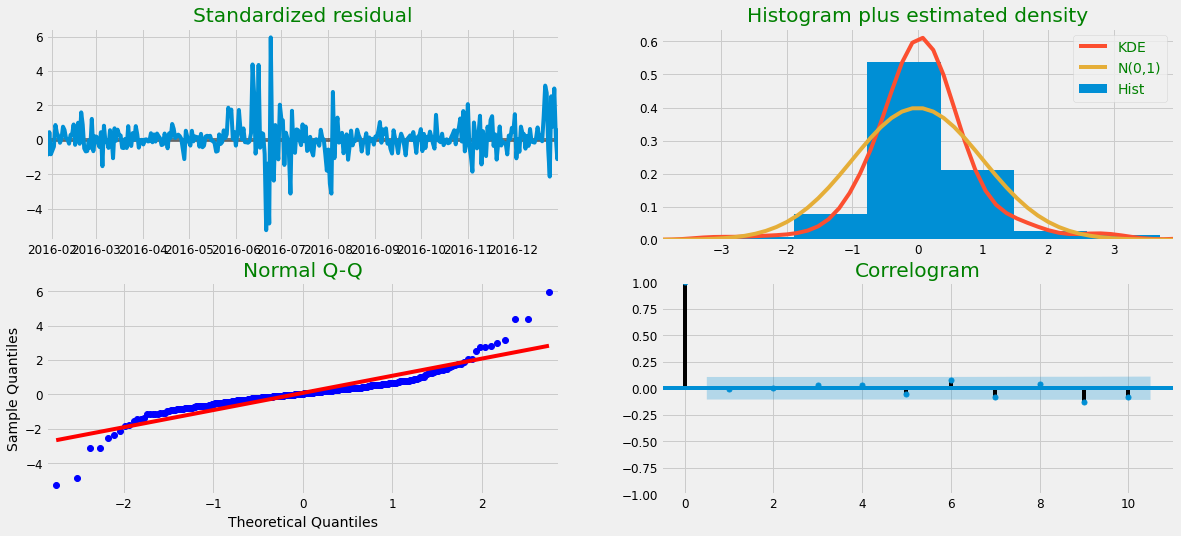

In [68]:
results.plot_diagnostics(figsize=(18, 8))
plt.show()

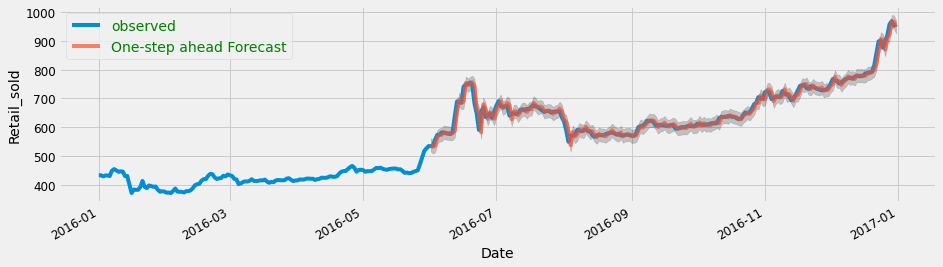

In [71]:
# comparing true values with forecast predictions
pred = results.get_prediction(start=pd.to_datetime('2016-06-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y_2016['weightedPrice'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Retail_sold')
plt.legend()
plt.show()

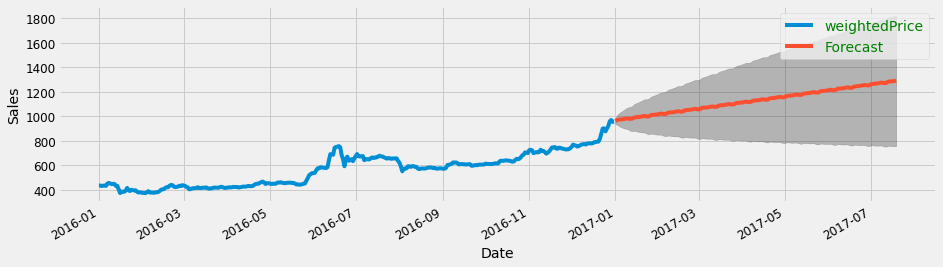

In [73]:
pred_uc = results.get_forecast(steps=200)
pred_ci = pred_uc.conf_int()
ax2 = y_2016.plot(figsize=(14, 4))
pred_uc.predicted_mean.plot(ax=ax2, label='Forecast')
ax2.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax2.set_xlabel('Date')
ax2.set_ylabel('Sales')
plt.legend()
plt.show()

In [74]:
# truth values of dataset
y_forecasted = pred.predicted_mean
y_forecasted.head(12)

2016-06-01    538.155242
2016-06-02    532.105560
2016-06-03    537.050916
2016-06-04    566.263971
2016-06-05    573.558701
2016-06-06    573.987672
2016-06-07    582.939338
2016-06-08    580.233610
2016-06-09    579.616049
2016-06-10    577.265603
2016-06-11    579.210041
2016-06-12    588.227647
Freq: D, dtype: float64

In [75]:
# visualizes upper and lower boundaries 
pred_ci.head(24)

,lower weightedPrice,upper weightedPrice
2017-01-01,936.773408,982.787251
2017-01-02,930.122335,1004.642844
2017-01-03,923.485695,1017.739432
2017-01-04,916.297574,1026.849708
2017-01-05,909.633665,1034.370339
2017-01-06,905.232960,1042.698376
2017-01-07,900.754815,1049.866313
2017-01-08,898.420936,1058.331919
2017-01-09,895.986582,1066.004695
2017-01-10,891.379171,1070.937186
